<a href="https://colab.research.google.com/github/google/neural-tangents/blob/main/notebooks/learning_curves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Precise Learning Curves and Higher-Order Scaling Limits for Dot Product Kernel Regression

Here we present a notebook that goes through the essential results in  [Xiao-Hu-Misiakiewicz-Lu-Pennington](https://arxiv.org/abs/2205.14846).

**Acknowledgement**. We thank Roman Novak for providing valuable feedback for this notebook, which makes the notebook 20x faster to run.  

Copyright 2022 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

### Imports & Utils

In [16]:
!pip install -q --upgrade pip
!pip install -q --upgrade jax[cuda11_cudnn805] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -q git+https://www.github.com/google/neural-tangents

/bin/sh: line 1: pip: command not found
/bin/sh: line 1: pip: command not found
/bin/sh: line 1: pip: command not found


In [28]:
import numpy as np
import jax.numpy as jnp

from jax import grad, jit, vmap
from jax import lax
from jax import config
from jax import random

import jax 
import time
import scipy as sp 
from jax import scipy as sp_jax


config.update('jax_enable_x64', True)

from functools import partial
import neural_tangents as nt
from neural_tangents import stax

In [18]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='white')


def format_plot(x='', y='', grid=True):  
  ax = plt.gca()
  plt.grid(grid)
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  

def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

### Helper Functions I: Genganbauer polynomials and Marchenko-Pastur distribution

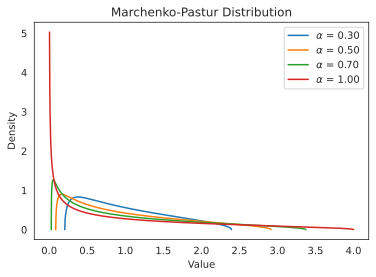

In [19]:
# Computing dimensions of spherical harmonics. 
def sh_dim(p, degree):
  if degree == 0: return 1 
  return int(
      sp.special.comb(degree + p - 3, degree - 1) * 
      (2 * degree + p - 2) / degree)


def sh_dim_sum(d, i):
  if i == 0: return 1 
  return sh_dim_sum(d, i - 1) + sh_dim(d, i)


# Gegenbauer polynomials; see https://en.wikipedia.org/wiki/Gegenbauer_polynomials. 
def gegenbauer_fn(x, a, n):
  if n == 0: return 1. 
  if n == 1: return 2 * a * x 
  return (
      (2 * x * (n + a - 1)) * gegenbauer_fn(x, a, n - 1) - 
      (n + 2 * a - 2) * gegenbauer_fn(x, a, n - 2)
      ) / n 


@partial(jit, static_argnums=(2,))
def normalized_gegenbauer(x, a, n):
  return gegenbauer_fn(x, a, n) / gegenbauer_fn(1., a, n)

  
# Marchenko-Pastur 
@jit 
def get_mp_density(alpha, n_points=1000): 
  a = (1 + jnp.sqrt(alpha)) ** 2
  b = (1 - jnp.sqrt(alpha)) ** 2
  def f(x):
    return 1 / (2 * jnp.pi) * ((a - x) * (x - b)) **0.5 / x / alpha 
  y = jnp.linspace(b, a, n_points)
  return y, f(y)


# Spherical data 
def get_input(n, d, key=jax.random.PRNGKey(10)):
  x = random.normal(key, (n, d))
  x /=  jnp.linalg.norm(x, axis=-1, keepdims=True)
  return x  


for alpha in [0.3, 0.5, 0.7, 1.,]:
  x, y = get_mp_density(alpha)
  plt.plot(x, y, label=f'$\\alpha$ = {alpha:.2f}')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.title('Marchenko-Pastur Distribution');


The first key result in the paper is that the spectrum of the Gram matrix of higher-order spherical harmonics, namely, $\frac 1m Y_r(X)^\top Y_r(X)$, follows the MP law.


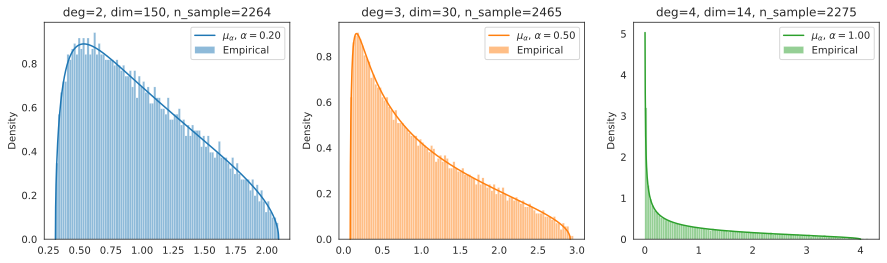

In [20]:
colors = (plt.rcParams['axes.prop_cycle'].by_key()['color'])
s = jax.random.PRNGKey(12)


@partial(jit, static_argnums=2)
def get_evals(x, d, degree):
    nngp = normalized_gegenbauer(x@x.T, d / 2. - 1, degree) 
    factor = jnp.trace(nngp) / x.shape[0]
    nngp /= factor
    evals = jnp.linalg.eigvalsh(nngp)
    return evals


alphas = [0.2, 0.5, 1.]
degrees = [2, 3, 4]
dims =  [150, 30, 14]


fig, axes = plt.subplots(1, 3, figsize=(5 * len(alphas), 4), sharey=False)


for i, (alpha, degree, dim) in enumerate(zip(alphas, degrees, dims)):  
  n_samples = int(sh_dim(dim, degree) * alpha)
  key, s = random.split(s)
  x = get_input(n_samples, dim, key=key) 
  evals = get_evals(x, dim, degree) 
  ax = axes[i]
  sns.histplot(evals, label='Empirical', color=colors[i], alpha=0.5, bins=100, 
               ax=ax, stat="density")
  x, y = get_mp_density(alpha)
  ax.plot(x, y, label=f'$\\mu_\\alpha$, $\\alpha=${alpha:.2f}', color=colors[i])
  ax.set_title(f'deg={degree}, dim={dim}, n_sample={n_samples}')
  ax.legend()
    
plt.show()


### Helper functions II: Kernels and Labels. 

In [21]:
def get_labels(x, label_degrees, energies, key=random.PRNGKey(20)):
  """We use monomials of the form `c1*x1 + c2*x1*x2 + c3*x1*x2*x3 + ... ` as our labels. """
  key, s = random.split(key)
  labels = [] 
  n = x.shape[0]
  for k, energy in zip(label_degrees, energies):
    out = jnp.ones_like(x)
    for l in range(k):
      out = jnp.multiply(out, jnp.roll(x, l, axis=-1)) 
    w = random.normal(key, (x.shape[1], 1))
    key, s = random.split(key)
    out = out @ w  
    out /= jnp.linalg.norm(out) 
    out *= jnp.sqrt(n)
    zeta = energy ** 0.5 
    labels += [out * zeta]
  labels = jnp.array(labels) 
  final_labels = jnp.sum(labels, axis=0) 
  return final_labels 


def get_kernel(x1, 
               x2, 
               degrees=[1, 2, 3, 4, 5, 6, 7],  
               evals=[1. / 2**i for i in range(7)], 
               ):
  """The kernel is constructed by summing Gegenbauer polynomials of various degrees."""
  n, d = x1.shape
  x11 = x1@x1.T
  x12 = x1@x2.T  
  kernel = 0.

  for degree, eval in zip(degrees, evals): 
    alpha = d / 2. - 1 
    nngp = normalized_gegenbauer(x12, alpha, degree)
    factor = jnp.trace(normalized_gegenbauer(x11, alpha, degree)) / n  
    nngp /= factor
    kernel += nngp * eval 

  return kernel


def get_conv_labels(x,  
                    label_degrees, 
                    energies,
                    key=random.PRNGKey(20),
                    ):
  
  _get = partial(get_labels,  
                 label_degrees=label_degrees,
                 energies=energies,
                 key=key
                 )
  _get_labels = jax.vmap(_get, in_axes=1)
  labels = _get_labels(x)
  return jnp.sum(labels, axis=0) / jnp.sqrt(p)


def get_conv_kernel(x1, 
                    x2, 
                    degrees=[1, 2, 3, 4, 5, 6, 7], 
                    evals=[1. / 2**i for i in range(10)]
                    ):
  _get_kernel = partial(get_kernel, degrees=degrees, evals=evals)
  _helper = jax.vmap(_get_kernel, in_axes=(1, 1)) 
  kernel = _helper(x1, x2)
  return jnp.mean(kernel, axis=0) 

In [36]:

def get_meta_loss(n=10000, 
                  d=60, 
                  p=1, 
                  kernel_degrees=[1, 2, 3, 4, 5, 6, 7], 
                  label_degrees=[1, 2, 3, 4, 5, 6, 7], 
                  energies=[1. / i for i in range(1, 10)], 
                  n_average=5, 
                  evals=[1./2**i for i in range(7)], 
                  key=random.PRNGKey(10)):
  
  ker_fn = get_kernel if p == 1 else get_conv_kernel
  ker_fn = partial(ker_fn, degrees=kernel_degrees, evals=evals)
  ker_fn = jit(ker_fn)

  @jit 
  def get_mse(ktd, kdd, y_train, y_test):
    residual = y_test - ktd @ sp_jax.linalg.solve(kdd, y_train, assume_a='pos')    
    return jnp.mean(jnp.square(residual)) / 2 
  
  n_trains = list(np.unique((1.3 ** np.arange(1, 100)).astype(int))) + [n]
  n_trains += [int((sh_dim_sum(d, i) - 1) * scale * p) for i in range(1, 7) for scale in [0.8, 0.9, 1., 1.1, 1.2]] 
  n_trains += [int(sh_dim(d, i) * p) for i in range(1, 7) ] + [int((sh_dim_sum(d, i)-1) * p) for i in range(1, 7)]
  n_trains = list(set(n_trains))
  n_trains = jnp.sort(jnp.array([n_train for n_train in n_trains if n_train <= n])) 

  n_test = 10000 

  losses = []
  key, s = random.split(key)

  if p == 1: 
    @jit 
    def get_input_label(key):
      x_all = get_input(n + n_test, d, key=key)
      y_all = get_labels(x_all, label_degrees, energies)
      return x_all, y_all 
  else: 
    @jit 
    def get_input_label(key):
      x_all = get_input((n + n_test) * p, d, key=key).reshape((n + 10000, p, d))
      y_all = get_conv_labels(x_all, label_degrees, energies)
      return x_all, y_all 

  for i in range(n_average):
    start_time = time.time() 
    key, s = random.split(s)

    x_all, y_all = get_input_label(key)
    x_train, x_test = x_all[:n], x_all[n:]
    y_train, y_test = y_all[:n], y_all[n:]

    kdd = ker_fn(x_train, x_train)
    ktd = ker_fn(x_test, x_train)

    losses.append(
        [get_mse(
            ktd[:, :n_train], 
            kdd[:n_train, :n_train], 
            y_train[:n_train], 
            y_test) 
        for n_train in n_trains]
        )
    run_time = time.time() - start_time
    print(f'The {i + 1} / {n_average} simulation takes {run_time:.2f} seconds.')
  losses_array = jnp.array(losses)

  return n_trains, losses_array


Setup some experiment parameters.

In [37]:
n = 12000 # maximal number of training samples
d = 24 # input dimension 
p = 1 # number of patches. p = 1 for fully-connected network kernels. 
n_average = 20
eigen_gap = 32 # Spectral gap between eigenspaces. 
evals = [eigen_gap ** (-i) for i in range(7)]
label_degrees = [1, 2, 3, 4, 5, 6, 7]
kernel_degrees = label_degrees 
energies = [1. / (i**2) for i in range(1, 10)]


Simulating the empirical sample-wise learning curves.

The 1 / 20 simulation takes 16.77 seconds.
The 2 / 20 simulation takes 1.18 seconds.
The 3 / 20 simulation takes 1.07 seconds.
The 4 / 20 simulation takes 1.08 seconds.
The 5 / 20 simulation takes 1.23 seconds.
The 6 / 20 simulation takes 1.27 seconds.
The 7 / 20 simulation takes 1.21 seconds.
The 8 / 20 simulation takes 1.27 seconds.
The 9 / 20 simulation takes 1.28 seconds.
The 10 / 20 simulation takes 1.24 seconds.
The 11 / 20 simulation takes 1.26 seconds.
The 12 / 20 simulation takes 1.23 seconds.
The 13 / 20 simulation takes 1.27 seconds.
The 14 / 20 simulation takes 1.22 seconds.
The 15 / 20 simulation takes 1.22 seconds.
The 16 / 20 simulation takes 1.19 seconds.
The 17 / 20 simulation takes 1.16 seconds.
The 18 / 20 simulation takes 1.09 seconds.
The 19 / 20 simulation takes 1.10 seconds.
The 20 / 20 simulation takes 1.08 seconds.


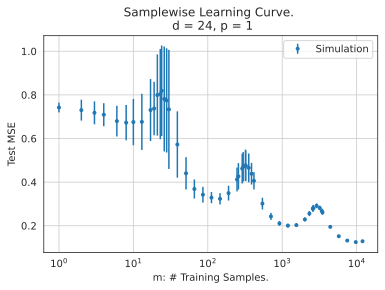

In [39]:
all_trains, all_loss = get_meta_loss(n=n, 
                                     d=d, 
                                     p=p, 
                                     kernel_degrees=kernel_degrees, 
                                     label_degrees=label_degrees, 
                                     evals=evals, 
                                     energies=energies, 
                                     n_average=n_average)

plt.errorbar(all_trains, 
             jnp.mean(all_loss, axis=0), 
             jnp.std(all_loss, axis=0),  
             label='Simulation', 
             markersize=3, 
             fmt='o')

plt.xscale('log')
plt.grid()
plt.title(f'Samplewise Learning Curve. \n d = {d}, p = {p}')
plt.xlabel(f'm: # Training Samples.')
plt.ylabel('Test MSE')
plt.legend();

### Analytical formulas for the bias and the variance.

To obtain the closed-form formulas for the bias and the variance, we need to evaluate several integrals (see Sec. C5 in the appendix). Fortunately, we can leave the evluation to https://www.wolframalpha.com/. 

In [25]:
# Eq (218) in Sec C.5
def int_bc_1(b, c):
  x = -1 + (1 + b + c) / (jnp.sqrt(b + b**2) + jnp.sqrt(c + c**2))
  return jnp.pi * x 


# Eq (219) in Sec C.5
def int_bc_2(b, c): 
  x = b + c + 2 * b * c + 2 * jnp.sqrt(b * c * (1 + b + c + b * c))
  x *= 2 * jnp.sqrt(b**2 + b)
  return jnp.pi / x 


# Eq (206) in C.5. 
def get_bias(N, m, eval):
  gamma = eval * m / N 
  alpha = 1. * N / m 
  b_plus = (1 + jnp.sqrt(alpha)) ** 2
  b_minus = (1 - jnp.sqrt(alpha)) ** 2
  delta = b_plus - b_minus
  b = (1 + gamma * b_minus) / delta / gamma 
  c = b_minus / delta 
  x = (delta * gamma) ** (-1) / (2 * jnp.pi * alpha * gamma) * int_bc_2(b, c)
  x = jnp.where(alpha > 1, x + (1 - 1. / alpha), x)
  return x / 2


# Eq (207) in C.5. 
def get_var(N, m, eval):
  gamma = eval * m / N 
  alpha = 1. * N / m 
  b_plus = (1 + jnp.sqrt(alpha)) ** 2
  b_minus = (1 - jnp.sqrt(alpha)) ** 2
  delta = b_plus - b_minus
  b = (1 + gamma * b_minus) / delta / gamma 
  c = b_minus / delta 
  x = 1. / (2 * jnp.pi * alpha * gamma) * int_bc_1(b, c)
  x = jnp.where(alpha > 1, x + (1 - 1. / alpha), x)
  return (x / 2 - get_bias(N, m, eval)) * alpha * gamma * 2

### Analytical formula for the sample-wise learning curves. 
Here, we implement Eq (20) of the paper. 

In [40]:
all_train = jnp.array(all_trains)

samples = jnp.geomspace(all_trains[0], all_trains[-1], 200)
samples = jnp.unique(jnp.sort(jnp.concatenate([samples, all_trains])))


def get_exact_prediction(
    evals=evals, 
    energies=energies, 
    label_degrees=label_degrees, 
    kernel_degrees=kernel_degrees):
  length = min(len(evals), len(energies), len(label_degrees)) - 1
  n_labels = len(label_degrees)
  n_kernels = len(kernel_degrees)

  @jit 
  def _prediction(m):
    bs = 0 
    vs = 0
    for i in range(length):
      reg = evals[i] / sum(evals[i+1: n_kernels])
      # Note that we compute the number of spherical harmonics with degree <= i. 
      N = sum([sh_dim(d, label_degrees[j]) for j in range(0, i + 1)]) * p 
      bs += energies[i] * get_bias(N, m , reg)
      vs += (1 + (get_var(N, m , reg))) * sum(energies[i+1:n_labels]) / 2 

    correction = 0
    for j in range(1, length):
      correction -= sum(energies[j: n_labels]) / 2 
    return bs, bs + vs + correction 

  return jnp.array([_prediction(m) for m in samples]).T

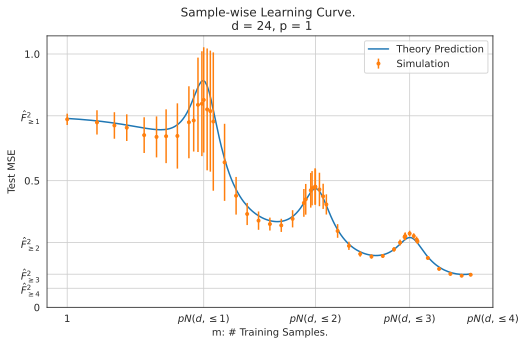

In [45]:
plt.figure(figsize=(8, 5))
b, bv = get_exact_prediction()
plt.plot(samples, bv, label='Theory Prediction')
plt.errorbar(all_trains , jnp.mean(all_loss, axis=0), jnp.std(all_loss, axis=0),  
            label='Simulation', 
            markersize=3, 
            fmt='o')


plt.xscale('log')
energies = jnp.array(energies)
critical_index = jnp.array([int(sh_dim(d, i)) for i in [1, 2, 3, 4]])

xs = [1, p * sh_dim(d, 1), p * sh_dim_sum(d, 2), p*sh_dim_sum(d, 3), p * sh_dim_sum(d, 4)]


labels = ['1', '$pN(d,\\leq 1)$', '$pN(d,\\leq 2)$', '$pN(d,\\leq 3)$','$pN(d,\\leq 4)$', ]
plt.xticks(xs, labels)


ys = [sum(energies[i:7]) / 2 for i in range(4)] + [0, 0.5, 1.]
labels = ['$\\hat{F}^2_{\geq 1}$',
          '$\\hat{F}^2_{\geq 2}$', 
          '$\\hat{F}^2_{\geq 3}$', 
          '$\\hat{F}^2_{\geq 4}$'] + [0, 0.5,  1.,]
plt.yticks(ys, labels)
plt.grid()
plt.title(f'Sample-wise Learning Curve. \n d = {d}, p = {p}')
plt.xlabel(f'm: # Training Samples.')
plt.ylabel('Test MSE')
plt.legend()
plt.show()
